In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans


In [2]:
def load_series(directory):
    """Loads every csv file from given directory. Assumes each contains two coulumns, first with date, second
    with the variable, without headers, and that name of the variable and of the place is contained in the name
    of the file in the form place_variable.csv."""
    dataframes_dict = {}
    files = os.listdir(directory)
    # Import each file as a separate DataFrame and assign headers
    for file_name in files:
        if file_name.endswith('.csv'):  # Check if the file is a CSV file
            # Extract headers from the filename by splitting it by "_"
            headers = file_name.split("_")
            header = "_".join(headers[1:])
            header = header.split(".")[0]
            header = "_".join(header.split(" "))
            headers = ["date", header]

            # Read the CSV file into a DataFrame, specifying column names as headers
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, names=headers, sep=";")
            df["date"] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')
    
            # Store the DataFrame in the dictionary with the filename as the key
            dataframes_dict[file_name] = df
    return dataframes_dict

In [3]:
def merge_site_data(dataframes_dict):
    sites = set(file.split("_")[0] for file in dataframes_dict.keys())
    site_dataframes = {}
    
    for site in sites:
        df = pd.DataFrame(columns=['date'])
        for file in dataframes_dict.keys():
            if file.startswith(site):
                site_df = dataframes_dict[file]
                df = pd.merge(df, site_df, on='date', how='outer')
        site_dataframes[site] = df
    return site_dataframes

In [4]:
def join_data(datas_dictionary):
    for site in datas_dictionary:
        datas_dictionary[site]["site"] = site
    result = pd.concat(list(datas_dictionary.values()), join='outer', ignore_index=True)
    return result

In [5]:
def clean_data(datas_dictionary, main_var = "prutok_computed"):
    cleaned_datas = {}
    for site in datas_dictionary:
        df = datas_dictionary[site]
        df = df.dropna(subset=[main_var])
        cleaned_datas[site] = df
    return cleaned_datas

In [6]:
def join_series(indicators, tol = 5, join = 1):
    """Given zero-one indicators, connects groups of successive ones if there is less than tol zeros seperating them."""
    ones_groups = (indicators.diff() != 0).cumsum()
    ones_counts = indicators.groupby(ones_groups).transform('size')
    groups_to_join = ones_counts < tol
    delete = 1 - join
    new_indicators = indicators.mask(groups_to_join & (indicators == delete), join)
    return new_indicators

In [7]:
def classify(data, main_var = "prutok_computed"
             , W_0 = 3
             , c_1 = 2.5, W_1 = 30
             , c_2 = 1, W_2 = 30, p_1 = 0.7
            , W_3 = 5, p_2 = 0.9
            , tol_vol_1 = 5, tol_vol_2 = 5
            , tol_rain_1 = 5, tol_rain_2 = 10):
    data[main_var + "_category"] = "OK"
    
    # priority 5
    const = data[main_var].rolling(window=W_0, center=True).std() == 0
    data.loc[const, main_var + "_category"] = "const_value"
    
    # priority 4
    subset = data[main_var] <= data[main_var].quantile(p_1)
    sd_p_1 = data[subset][main_var].std()
    K = c_2*sd_p_1
    sd_2 = data[main_var].rolling(window=W_2, center=True).std()
    high_vol_orig = sd_2 > K
    high_vol = join_series(high_vol_orig.astype(int), tol = tol_vol_1, join = 1)  # group nearby islands of volatility
    high_vol = join_series(high_vol, tol = tol_vol_2, join = 0)  # delete small islands of volatility
    high_vol = high_vol.astype(bool)
    data.loc[high_vol, main_var + "_category"] = "volatile"
    
    # priority 3
    MA = data[main_var].rolling(window=W_3, center=True).mean()
    rain_threshold = data[main_var].quantile(p_2)
    rainy = MA >= rain_threshold
    high_vol_rain = high_vol_orig & rainy
    high_vol_rain = join_series(high_vol_rain.astype(int), tol = tol_rain_1, join = 1)  # group nearby islands of rain
    high_vol_rain = join_series(high_vol_rain, tol = tol_rain_2, join = 0)  # delete small islands of rain
    high_vol_rain = high_vol_rain.astype(bool)
    data.loc[high_vol_rain, main_var + "_category"] = "volatile_rain"
    
    # priority 2
    zeros = data[main_var] == 0
    data.loc[zeros, main_var + "_category"] = "zero_value"
    
    # priority 1
    first_diff = data[main_var].diff()
    first_diff_plus = first_diff.shift(-1)
    sd_1 = first_diff.rolling(window=W_1, center=True).std()
    T = c_1*sd_1
    outliers = ((first_diff > T) & (first_diff_plus < -T)) | ((first_diff < -T) & (first_diff_plus > T))
    data.loc[outliers, main_var + "_category"] = "outlier"
    
    dummies = pd.get_dummies(data[main_var + "_category"], prefix=main_var)
    for col in dummies.columns:
        data[col] = np.where(dummies[col] == 1, data[main_var], np.nan)
    #data = pd.concat([data, dummies], axis=1)
    return data

In [8]:
def plot_categories(df, main_var, unit, categories = "all", fig_size = None):
    
    if categories == "all":
        cats = list(df[main_var + "_category"].unique())
        if "OK" in cats:
            cats.remove("OK")
    else:
        cats = categories
    cols = [main_var + "_" + cat for cat in cats]
    
    if fig_size is None: 
        fig_size = (10, 6)
    plt.figure(figsize=fig_size)
    plt.plot(df['date'], df[main_var], label=main_var, color='blue')  # Line plot for var1

    # Plot special categories as scatter plots with different markers
    markers = {"volatile_rain":'o', 'const_value':'s', 'outlier':'^', 'zero_value':'D','volatile':"*"}  # Define markers for each category (max 5 categories)
    colors = ["green", "brown", "red", "yellow", "orange"]
    colors = {key: col for key, col in zip(markers.keys(), colors)}
    for i, column in enumerate(cols):
        cat = cats[i]
        if cat in ["volatile_rain", "volatile"]:
            plt.plot(df['date'], df[column], label=cat, linestyle='-', marker=markers[cat], color = colors[cat])
        else:
            plt.scatter(df['date'], df[column], label=cat, marker=markers[cat], color = colors[cat])

    plt.xlabel('Date and Time')
    plt.ylabel(main_var)
    plt.title(f'Time Series for {unit}')
    plt.legend()
    plt.show()

In [9]:
class TS_Class:
    
    def __init__(self, data, main_var = "Prietok", 
                 start_date = None, end_date = None, periodicity = "2T", check_per = True):
        if start_date is None:
            start_date = data["date"].min()
        self.start_date = start_date
        if end_date is None:
            end_date = data["date"].max()
        self.end_date = end_date
        self.periodicity = periodicity
        
        self.data = data
        if check_per:       # ensuring we have constant periodicity in observations
            self.enforce_periodicity(start_date, end_date, periodicity)
        
        self.check_per = check_per
        self.main_var = main_var
        self.data[main_var + "_diff_1"] = data[main_var].diff()
        self.data[main_var + "_diff_2"] = self.data[main_var + "_diff_1"].diff()
        self.models = {}
    
    def enforce_periodicity(self, start_date = None, end_date = None, periodicity = None):
        if start_date is None: start_date = self.start_date
        if end_date is None: end_date = self.end_date
        if periodicity is None: periodicity = self.periodicity
        date_range = pd.date_range(start=start_date, end=end_date, freq=periodicity)
        df = pd.DataFrame({'date': date_range})
        self.data = df.merge(self.data, on='date', how='left')   # ensuring we have constant periodicity in observations
    
    def get_period_data(self, period, start_time = None, which = 1, subset = None):
        """Period is either 'daily', 'weekly', or whole number indicating number of hours."""
        used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
        if type(period) == int:
            if start_time is None or start_time == "start":
                reference_point = used_data["date"].min()
            else:
                start_time = datetime.strptime(start_time, "%H:%M:%S")
                reference_point = used_data[used_data['date'].dt.time == start_time.time()]["date"].min()
                used_data = used_data[used_data["date"]>= reference_point]    # cut off observations before start_time
            used_data["period_index"] = used_data["date"].apply(lambda x: (x-reference_point).total_seconds() // (period * 3600))
            used_data["period_name"] = used_data["period_index"].apply(
                lambda x:f"[{reference_point + timedelta(hours=period*x)} -- {reference_point + timedelta(hours=period*(x+1))})")
        
        elif period == "daily":
            used_data['period_name'] = used_data['date'].dt.date
            
        elif period == "weekly":
            first = used_data['date'].dt.strftime('%Y-%W').apply(
                lambda x: x.split("-")).apply(
                lambda y: datetime.strptime(f'{y[0]}-W{y[1]}-1', "%Y-W%U-%w") )
            used_data['period_name'] = first.apply(
                lambda x: f"{x.strftime('%Y-%m-%d')} -- {(x+timedelta(days=6)).strftime('%Y-%m-%d')}")
                       
        else:
            raise NameError('Period which is not recognized have been entered. "weekly" or "daily" are expected.')
        
        if which == 1:
            self.period_data = used_data.groupby('period_name')
        else:
            self.period_data_2 = used_data.groupby('period_name')
        
    def get_y_lim(self, value, negative = False):
        if negative:
            value = - value
        if value < 0.05: return value*1.1
        if value < 0.09: return 0.1
        if value < 0.47: return 0.5
        if value < 0.9: return 1
        if value < 2.45: return 2.5
        if value < 4.9: return 5
        if value < 9.5: return 10
        if value < 19: return 20
        return value*1.1
    
    def get_rob_subset(self, variable, rob_quantile, two_sided):
        subset = self.data[variable] < self.data[variable].quantile(rob_quantile)
        if two_sided:
            L = self.data[variable].quantile(1-rob_quantile)
            U = self.data[variable].quantile(rob_quantile)
            subset =  self.data[variable].apply(lambda x: L<x<U)
        return subset
    
    def get_measures(self, variable, include, window, which = 1, 
                     quantile = 0.5, rob_quantile = 0.8, two_sided_rob_q = False, rob_q_mult = 1):   
        suff = "" if which == 1 else "_2"
        if two_sided_rob_q:
            rob_quantile = 0.5 + rob_quantile/2
        if "CMA" in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
        if ("CMA_bounds" in include) or ("CMA_bounds_2sd" in include):
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            self.data['Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
            self.data['CMA_upper'+suff] = self.data['Centered_Moving_Average'+suff] + self.data['Centered_Moving_SD'+suff]
            self.data['CMA_lower'+suff] = self.data['Centered_Moving_Average'+suff] - self.data['Centered_Moving_SD'+suff]
            if "CMA_bounds_2sd" in include:
                self.data['CMA_upper_2sd'+suff] = self.data['Centered_Moving_Average'+suff] + 2*self.data['Centered_Moving_SD'+suff]
                self.data['CMA_lower_2sd'+suff] = self.data['Centered_Moving_Average'+suff] - 2*self.data['Centered_Moving_SD'+suff]
        if "CMA_rob_bounds"  in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            robust_sd = self.data[subset][variable].std()
            self.data['CMA_upper_rob'+suff] = self.data['Centered_Moving_Average'+suff] + rob_q_mult*robust_sd
            self.data['CMA_lower_rob'+suff] = self.data['Centered_Moving_Average'+suff] - rob_q_mult*robust_sd
                
        if "MA" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
        if ("MA_bounds" in include) or ("MA_bounds_2sd" in include):
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            self.data['Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
            self.data['MA_upper'+suff] = self.data['Moving_Average'+suff] + self.data['Moving_SD'+suff]
            self.data['MA_lower'+suff] = self.data['Moving_Average'+suff] - self.data['Moving_SD'+suff]
            if "MA_bounds_2sd" in include:
                self.data['MA_upper_2sd'+suff] = self.data['Moving_Average'+suff] + 2*self.data['Moving_SD'+suff]
                self.data['MA_lower_2sd'+suff] = self.data['Moving_Average'+suff] - 2*self.data['Moving_SD'+suff]
        if "MA_rob_bounds" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            robust_sd = self.data[subset][variable].std()
            self.data['MA_upper_rob'+suff] = self.data['Moving_Average'+suff] + rob_q_mult*robust_sd
            self.data['MA_lower_rob'+suff] = self.data['Moving_Average'+suff] - rob_q_mult*robust_sd
        
        if "CMSD" in include:
            self.data['Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
        if "MSD" in include:
            self.data['Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
        if "tot_avg" in include:
            self.data['total_avg'+suff] = self.data[variable].mean()
        if "quant" in include:
            self.data['quantile'+suff] = self.data[variable].quantile(quantile)
        if "robust_avg" in include:
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            self.data['r_avg'+suff] = self.data[subset][variable].mean()
            
    
    def get_ax(self, ax, group_data, unit, variable, include, rain_lims, which, include_rain = True, marker = None):  
        suff = "" if which == 1 else "_2"
        ax.plot(group_data['date'], group_data[variable], label = variable)
        include_c = include.copy()   
        if "CMA" in include_c:
            ax.plot(group_data['date'], group_data['Centered_Moving_Average'+suff], color="red", label = "CMA")
            include_c.remove("CMA")
        
        if "CMA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper_2sd'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['CMA_lower_2sd'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds_2sd")
        if "CMA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['CMA_lower'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds")
        
        if "CMA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper_rob'+suff], color="black", label = "CMA_rob_Up")
            ax.plot(group_data['date'], group_data['CMA_lower_rob'+suff], color="black", label = "CMA_rob_L")
            include_c.remove("CMA_rob_bounds")
            
        if "MA" in include_c:
            ax.plot(group_data['date'], group_data['Moving_Average'+suff], color="brown", label = "MA")
            include_c.remove("MA")
        if "MA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['MA_lower'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds")
        if "MA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper_2sd'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['MA_lower_2sd'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds_2sd")
        if "MA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper_rob'+suff], color="black", label = "MA_rob_Up")
            ax.plot(group_data['date'], group_data['MA_lower_rob'+suff], color="black", label = "MA_rob_L")
            include_c.remove("MA_rob_bounds")
            
        if "CMSD" in include_c:
            ax.plot(group_data['date'], group_data['Centered_Moving_SD'+suff], color="green", label = "CMSD")
            include_c.remove("CMSD")
        if "MSD" in include_c:
            ax.plot(group_data['date'], group_data['Moving_SD'+suff], color="black", label = "MSD")
            include_c.remove("MSD")
        if "tot_avg" in include_c:
            ax.plot(group_data['date'], group_data['total_avg'+suff], color="black", label = "tot_avg")
            include_c.remove("tot_avg")
        if "quant" in include_c:
            ax.plot(group_data['date'], group_data['quantile'+suff], color="black", label = "quantile")
            include_c.remove("quant")
        if "robust_avg" in include_c:
            ax.plot(group_data['date'], group_data['r_avg'+suff], color="black", label = "robust_avg")
            include_c.remove("robust_avg")
        
        max_y = group_data[variable].max()
        min_y = group_data[variable].min()
        #print(variable+str(min_y))    #########
        #print(variable+str(max_y))    #########
        #print(variable+" no-nan "+str(max_y))    #########
        for item in include_c:
            if item in group_data.columns:
                ax.plot(group_data['date'], group_data[item], label = item)
                max_y = max(max_y, group_data[item].max())
                min_y = min(min_y, group_data[item].min())
                #print(item+str(min_y))    #########
               # print(item+str(max_y))    #########
                        
        ax.set_title(f'Time Series for {unit}')
        ax.set_xlabel('Date and Time')
        ax.set_ylabel(variable)
        ax.legend(loc="upper left")
        ylim_up = self.get_y_lim(max_y)
        ylim_down = -self.get_y_lim(min_y, True) if min_y < 0 else 0
 #       print("down "+str(ylim_down))            ##############
 #       print("up "+str(ylim_up))
        try:
            ax.set_ylim(ylim_down, ylim_up)
        except:
            print("down "+str(ylim_down))            ##############
            print("up "+str(min_y))
        for line in ax.lines:
            line.set_marker(marker)
            
        if include_rain:
            ax2 = ax.twinx()
            ax2.set_ylim(*rain_lims)
            ax2.plot(group_data["date"], group_data['rain_2m'], label='rain', color='green')
            ax2.invert_yaxis()
            ax2.set_ylabel('rain (Upside-Down)', color='green')
            ax2.tick_params(axis='y', labelcolor='green')
            ax2.legend(loc='upper right')
            return (ax, ax2)
        return (ax, "")
        
    def plot(self, variable = None, period = "all", start_time = None, subset = None, 
             quantile = 0.5, rob_quantile = 0.8, two_sided_rob_q = False, rob_q_mult = 1,
             include = ["CMA", "CMA_bounds"], window = 30, rain_lims = (0,5), fig_size = None, 
            variable_2 = None, start_time_2 = None, include_2 = ["CMA", "CMA_bounds"], window_2 = 30, 
            quantile_2 = 0.5, rob_quantile_2 = 0.8, two_sided_rob_q_2 = False, rob_q_mult_2 = 1, 
             double_plot = False, include_rain = True, marker = None):
        if variable is None:
            variable = self.main_var
        
        self.get_measures(variable, include, window, which = 1, quantile = quantile, rob_quantile = rob_quantile, 
                          two_sided_rob_q = two_sided_rob_q, rob_q_mult = rob_q_mult)
        if start_time_2 is not None:
            if variable_2 is None: variable_2 = variable
            self.get_measures(variable_2, include_2, window_2, which = 2, quantile = quantile_2, 
                              rob_quantile = rob_quantile_2, two_sided_rob_q = two_sided_rob_q_2, rob_q_mult = rob_q_mult_2)
                
        if period == "all":
            self.data["const"] = "whole data"
            used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
            self.period_data = used_data.groupby("const")
        else:
            self.get_period_data(period, start_time, 1, subset)
        
        if start_time_2 is None:
            self.period_data_2 = self.period_data
        else:
            if period == "all":
                self.data["const"] = "whole data"
                used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
                self.period_data_2 = used_data.groupby("const")
            else:
                self.get_period_data(period, start_time_2, 2, subset)
            
        for grouped_1, grouped_2 in zip(self.period_data,self.period_data_2):
            unit_1, group_data_1 = grouped_1
            unit_2, group_data_2 = grouped_2
            
            if double_plot:
                group_data_1.set_index('date', inplace=True)
                group_data_2.set_index('date', inplace=True)
                group_data_1[variable].plot(xlabel = 'Date and Time', ylabel = variable, label = variable)
                group_data_2[variable_2].plot(label = variable_2)
                
                plt.title(f'Time Series for {unit_1}')
                plt.legend(loc="upper left")
                plt.show()
                continue
            
            if start_time_2 is not None:
                if fig_size is None: 
                    fig_size = (19, 6)
                fig, ax = plt.subplots(1, 2, figsize=fig_size)
                ax[0], axb1 = self.get_ax(ax[0], group_data_1, unit_1, variable, include, rain_lims, 1, include_rain, marker)
                ax[1], axb2 = self.get_ax(ax[1], group_data_2, unit_2, variable_2, include_2, rain_lims, 2, include_rain, marker)
            else:
                if fig_size is None: 
                    fig_size = (10, 6)
                fig, ax = plt.subplots(figsize=fig_size)
                ax, axb1 = self.get_ax(ax, group_data_1, unit_1, variable, include, rain_lims, 1, include_rain, marker)
            plt.grid(True)
            plt.show()
            
    def groupby(self, groupby):
        if groupby is None:
            self.data["const"] = "whole data"
            grouped = self.data.groupby("const")
        else:
            if groupby == "daily":
                self.data['period_name'] = self.data['date'].dt.date
                grouped = self.data.groupby("period_name")
            elif groupby == "weekly":
                self.data['period_name'] = self.data['date'].dt.strftime('%Y-%W')
                grouped = self.data.groupby("period_name")
            else:
                grouped = self.data.groupby(groupby)
        return grouped
    
    def get_ETS(self, variable, model_name, groupby = None, show_progress = True,
                error="add", trend="add", seasonal="add", damped_trend=False, seasonal_periods=720):
        """Note: there is 720 observations per day, for 1 day periodicity we need 720 seasonal components, which is too 
        many for practical estimatation - careful about seasonal components."""
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)
                        
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ETSModel(grouped_data[variable], error=error, trend=trend, seasonal=seasonal, 
                                            damped_trend=damped_trend, seasonal_periods=seasonal_periods)
            result = model.fit()
            grouped_data[model_name + "_fitted"] = result.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def get_ARIMA(self, p, d, q, model_name, variable = None,  groupby = None, show_progress = True):
        if variable is None: variable = self.main_var
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)           
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ARIMA(grouped_data[variable], order=(p, d, q))
            results = model.fit()
            grouped_data[model_name + "_fitted"] = results.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def ARIMA_diagnostics(self, results, unit, model_name, show_summary = True):
        print("ARIMA diagnostics for " + model_name + " " + str(unit))
        if show_summary:
            print(results.summary())
        residuals = results.resid
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax[0, 0].plot(residuals)
        ax[0, 0].set_title('Residuals')
        lags_1 = min(40, len(residuals)-1)
        lags_2 = min(40, int(len(residuals)/2)-2)
        sm.graphics.tsa.plot_acf(residuals, lags=lags_1, ax=ax[0, 1])
        sm.graphics.tsa.plot_pacf(residuals, lags=lags_2, ax=ax[1, 0])
        plt.show()

        # Ljung-Box test for autocorrelation in residuals
        acf, q_val, p_val = sm.tsa.acf(residuals, fft=True, qstat=True)
        p_val_df = pd.DataFrame({'Lag': range(1, len(p_val) + 1), 'P-Value': p_val})

        print(p_val_df)
    
    def ARIMAs_diagnostics(self, model_name, subset = None):
        models = self.models[model_name]
        if subset is not None:
            models = models[subset]
        for unit, mod, res in models:
            self.ARIMA_diagnostics(res, unit, model_name)
            
    def get_time_trend(self, values, give = "slope"):
        """Values should have a data series format with specified index which represents time order."""
        X = sm.add_constant(values.index)
        model = sm.OLS(values, X).fit()
        if give == "slope":
            return model.params[1]
        if give == "constant":
            return model.params[0]
        if give == "model":
            return model
        
    def copy(self):
        data_copy = self.data.copy()
        self_copy = TS_Class(data_copy, self.main_var, 
                 self.start_date, self.end_date, self.periodicity, self.check_per)
        return self_copy
    
    def classify(self, data = None, main_var = None, W_0 = 3
             , c_1 = 2.5, W_1 = 30
             , c_2 = 1, W_2 = 30, p_1 = 0.7
            , W_3 = 5, p_2 = 0.9
            , tol_vol_1 = 5, tol_vol_2 = 5
            , tol_rain_1 = 5, tol_rain_2 = 10):
                
        ret = True
        if data is None: 
            data = self.data
            ret = False
        if main_var is None:
            main_var = self.main_var
            
        data = classify(data, main_var, W_0, c_1, W_1, c_2, W_2, p_1, W_3, p_2
                        ,tol_vol_1, tol_vol_2, tol_rain_1, tol_rain_2)
        if not ret:
            self.data = data
        else:
            return data
    
    def plot_categories(self, categories = "all", main_var = None, only_events = False
                        ,period = "all", start_time = None, subset = None, fig_size = None):
        if main_var is None:
            main_var = self.main_var
        
        # TO DO: if only_events choose only days in which there is event from categories (not "OK")
        
        if period == "all":
            self.data["const"] = "whole data"
            used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
            self.period_data = used_data.groupby("const")
        else:
            self.get_period_data(period, start_time, 1, subset)
        
        for grouped in self.period_data:
            unit, group_data = grouped
            plot_categories(group_data, main_var, unit, categories, fig_size)
    

In [10]:
class Data_Explorer:
    
    def __init__(self, datas_dictionary, main_vars = None, 
                 start_dates = None, end_dates = None, periodicities = None, check_pers = None):
        datas_dictionary = {site: datas_dictionary[site] for site in sorted(datas_dictionary)}  # sort dictionary by keys
        self.data_dict = datas_dictionary
        self.sites = list(datas_dictionary.keys())
        self.joined_data = join_data(datas_dictionary)
        
        if main_vars is None: main_vars = {site: "prutok_computed" for site in self.sites}
        if start_dates is None: start_dates = {site: None for site in self.sites}
        if end_dates is None: end_dates = {site: None for site in self.sites}
        if periodicities is None: periodicities = {site: "2T" for site in self.sites}
        if check_pers is None: check_pers = {site: True for site in self.sites}
                
        self.TS_objects = {site: TS_Class(
            datas_dictionary[site], main_var = main_vars[site] 
            , start_date = start_dates[site], end_date = end_dates[site]
            , periodicity = periodicities[site], check_per = check_pers[site]
        ) for site in self.sites}
        
        self.TS_objects["joined"] = TS_Class(self.joined_data, main_var = main_vars[self.sites[0]]
                                            , start_date = start_dates[self.sites[0]], end_date = end_dates[self.sites[0]]
                                            , periodicity = periodicities[self.sites[0]], check_per = False)
        self.main_sites = self.sites.copy()
        self.sites.append("joined")
        self.data_dict["joined"] = self.joined_data
        
        self.main_vars = {site: self.TS_objects[site].main_var for site in self.sites}
        self.start_dates = {site: self.TS_objects[site].start_date for site in self.sites}
        self.end_dates = {site: self.TS_objects[site].end_date for site in self.sites}
        self.periodicities = {site: self.TS_objects[site].periodicity for site in self.sites}

In [11]:
path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\dhi_data2"

In [12]:
files = os.listdir(path)

In [13]:
dataframes_dict = load_series(path)

In [14]:
site_dataframes = merge_site_data(dataframes_dict)
site_dataframes = clean_data(site_dataframes)

In [15]:
first_data = pd.read_csv("d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\Q01_HL_23.csv", skiprows=[0,1,2, 3],
                   names = ["date"," Hl-Vega-OK", "Hl-US-Odlehc", "Hladina KDO", "Teplota KDO", 
                                       "Rychlost KDO", "Prietok_l", "Napatie_AKU2", "Napatie_AKU",  "prutok_computed"],
                  sep = ";", decimal=',')

rain = pd.read_csv("d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\SR02_H2_27374.csv", skiprows=[0,1,2, 3],
                  usecols = [0,1], names = ["date","rain"],
                  sep = ";", decimal=',')

first_data["date"] = pd.to_datetime(first_data['date'], format='%d.%m.%Y %H:%M:%S')
rain["date"] = pd.to_datetime(rain['date'], format='%d.%m.%Y %H:%M:%S')
rain.replace(r'^\s*$', np.nan, regex=True, inplace=True)
rain["rain"] = pd.to_numeric(rain["rain"].str.replace(',', '.') )

rain.set_index('date', inplace=True)

# Resample data to two-minute intervals and calculate the sum for each two-minute period
rain['rain_2m'] = rain['rain'].resample('2T').sum()

# Assign NaN to odd minutes
rain['rain_2m'][rain.index.minute % 2 != 0] = np.nan

rain["date"] = rain.index
rain.index = range(rain.shape[0])
first_data = first_data.merge(rain, on='date', how='left')

In [16]:
site_dataframes["first"] = first_data

In [17]:
explorer = Data_Explorer(site_dataframes)

In [18]:
for site in explorer.main_sites:
    explorer.TS_objects[site].classify()

In [19]:
ts_data = explorer.TS_objects['first'].copy() 
ts_data.classify()

In [20]:
subset_ = ts_data.data["date"].dt.date == pd.to_datetime("2022-06-04").date()
subset1 = ts_data.data[subset_].index

In [21]:
subset_ = ts_data.data["date"].dt.date == pd.to_datetime("2022-06-11").date()
subset2 = ts_data.data[subset_].index

# Agenda
* events and their identification
* correction or errors
* feedback, others

notation: 

$v_t$ denotes flow at time $t$

$\Delta v_t$ denotes first differences of flow

MA$_t$(W) denotes centred moving average with window size W measured at time $t$

Msd$_t$(W) denotes centred moving standard deviation with window size W measured at time $t$

# Events
 - outliers, zero or constant values, and periods of heightened volatility
 
Just heuristical rules for identification, some are quite rough. Could be optimized if we had specific targets to aim for.

### outliers
Flow values which seems odd compared to nearby past and future values. $v_t$ is identified as outlier if flow jumped by high margin up and then immediately fell by high margin down (or vice versa, fell and than rised back), i.e.
$$ \Delta v_t > T_t \qquad \text{and} \qquad \Delta v_{t+1} < -T_t $$
or both inequalities in the opposite direction.

Threshold is based on moving standard deviation **of the first differences of the flow** as 
$$ T_t = c_1 \cdot Msd_t(W_1). $$
We use as default values $c_1 = 2.5$ and window $W_1 = 30$.

**data requirements**: for Msd we need $W_1$ observations, that is we can identify outliers with 15 periods = **30 minutes delay** with the default choice of $W_1$ but should probably work well with smaller windows, too.

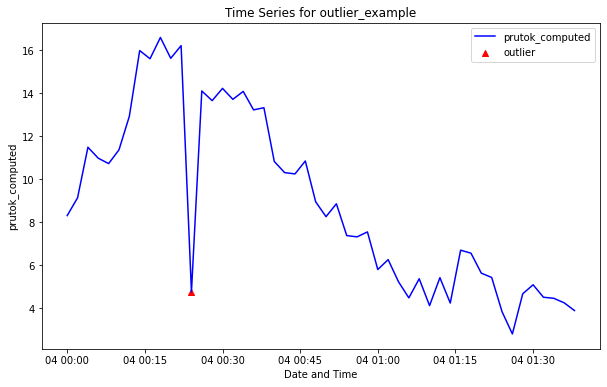

In [22]:
plot_categories(ts_data.data.loc[subset1[:50]], "prutok_computed", "outlier_example", categories = ["outlier"])

### Zero and constant values
Zero values are simply those for which $v_t = 0$. We identify constant observations as those which have not changed in comparison to past and future, i.e. observation at $t$ is constant if $v_{t-1} = v_t = v_{t+1}$. Technically, this is done by identifying zero moving standard deviation of the flow  with window 3,
$$ Msd_t(W_0) = 0 $$
with $W_0 = 3$. Generally we can be more lenient by setting $W_0$ to some higher value.

**data requirements**: immediate identification of zero values and delay of only 1 period for constant values.

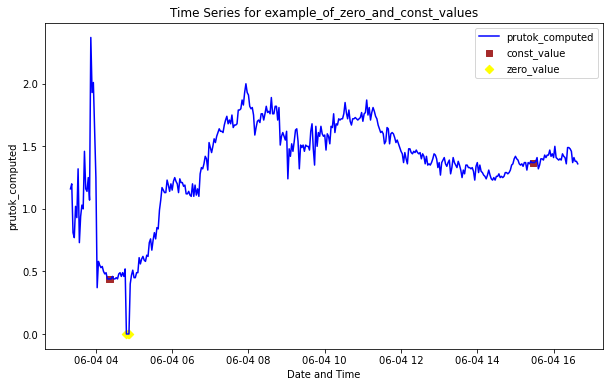

In [23]:
plot_categories(ts_data.data.loc[subset1[100:500]], "prutok_computed", "example_of_zero_and_const_values")

### periods of high volatility
Sometimes, flow is suspiciously volatile. We identify this by high values of its moving standard deviation,
$$ Msd_t(W_2) > K $$
where we chose window $W_2 = 30$. Threshold is determined as overall standard deviation for lower 0.7 quantile of flow observations (rough controlling for rain disturbances),
$$ K = c_2 \cdot \sigma_{p_1} $$
with $c_2 = 1$ and $p_1 = 0.7$, $\sigma_{p_1} = sd(v_t; v_t \leq p_1\text{th quantile of the flow})$. These are default values, choosing lower $p_1$ or $c_2$ would be more sensitive to heightened volatility and vice versa.

We furthemore identify groups of high volatility observations (successive periods in which high volatility is recognized) and if there are two groups seperated by less then $tol\_vol_1 = 5$ non-volatile observations we merge them by setting observations between them as high-volatility observations as well. On the other hand if a group of highly volatile observations has less then $tol\_vol_2 = 5$ members we deem it as a false signal and categorize them as OK.

**data requirements:** We need $W_2$ observations for moving standard deviation calculations, i.e. **delay of 15 periods** at default setting. But we also need to have set the threshold $K$ for which we use the whole history of the data. If necessary could be set expertly to some reasonable value.

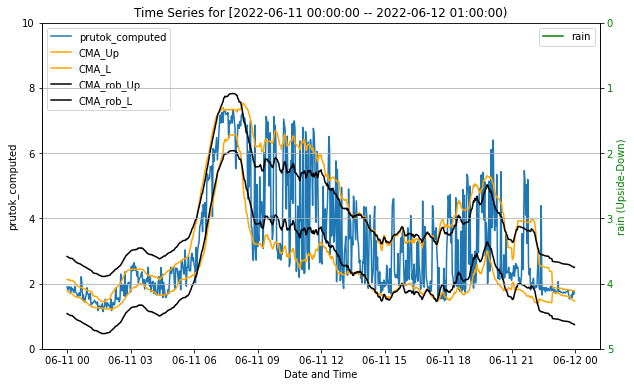

In [24]:
ts_data.plot(include=["CMA_rob_bounds","CMA_bounds"], period=25, start_time="0:00:00", subset = subset2,
            rob_q_mult = 1, rob_quantile=0.7)

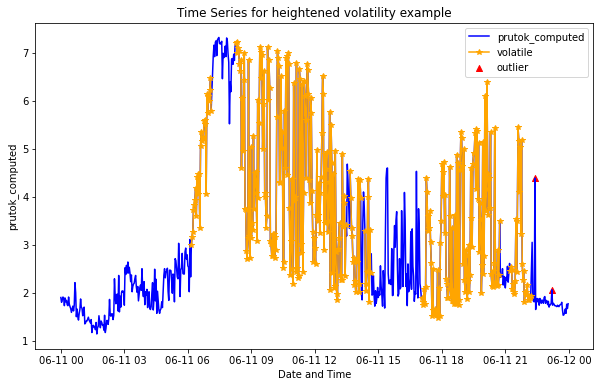

In [25]:
plot_categories(ts_data.data.loc[subset2], "prutok_computed", "heightened volatility example")

### high volatility due to rain
When it is raining it is natural and OK that volatility is high. We thus try to recognize when this happens due to rain. Rain is usually accompanied by heightened level of the flow, hence we set conditions for this category as
$$ \text{heightened volatility and }  MA_t(W_3) \geq p_2\text{th percentile of the flow.} $$
As default we set $p_2 = 0.9$ and $W_3 = 5$.

We furthermore perform same kind of grouping as for general high volatility, this time with $tol\_rain_1 = 5$ and $wol\_rain_2 = 10$.

**data requirements**: This category is subset of heightened volatility, so **same as above**. Additionally, we need moving average with window $W_3$ but this window is in default setting smaller than the one required for heightened volatility identification. We use the whole history of the data for calculating $p_2$th percentile of the flow but if necessary, this  could be replaced by some expertly chosen value.

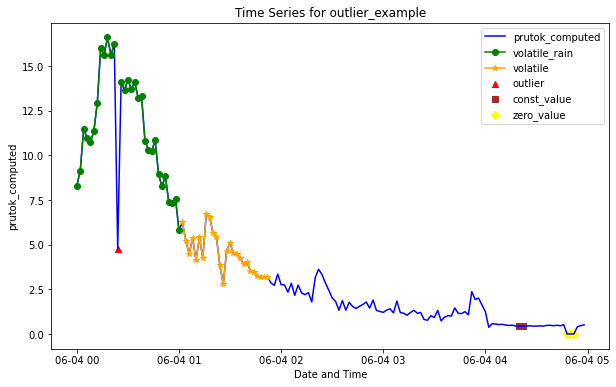

In [26]:
plot_categories(ts_data.data.loc[subset1[:150]], "prutok_computed", "outlier_example", categories = "all")

## Hierarchy of categories
We categorize each observation to just one group. Since an observation can sometimes satisfy conditions for multiple categories we set hierarchy as follows (from the most prefered category to the most overwritten):
1) outliers

2) zero values 

3) volatility due to rain

4) general volatility

5) constant values

Observations which do not belong to any of these categories are considered to be OK.

# Corrections

Not implemented yet (in few more days), only discussion:

* outliers: when isolated just replace $v_t$ by average($v_{t-1}, v_{t+1}$). If there are multiple outliers in succession  (does not usually happen) then apply MA(5) or MA(15). Hence usually **trivial data requirements**.

* high volatility due to rain: we suppose this is natural and apply **no correction** to this.

* high volatility: replacing $v_t$ with MA(5) or MA(15) in order to smooth the series and eliminate noise, hence only small data requirements - **delay of 3 or 8 periods**. It was mentioned that estimates of variance of errors would be welcomed - can be achieved by ARIMA models.

### zero or constant values: 
Most tricky category to repair, many different possibilities. Isolated instances or if there are only few successive observations (< 8) can be replaced e.g. by MA(15) or MA(30). 

For medium periodsof successive errors (8 to 30)  of this type standard ARIMA or ETS predictions can be reasonable solution. These can be estimated on historical data, window of 50-100 observations should be quite enough (if neccessary perhaps even as few as 30). 

For longer gaps in data it would be worthwile to try to estimate cyclical components. Our first approach is to use dummy estimates of cyclical components, other common possibility is to use sinusoids of different frequencies. Cycles can be computed e.g. for individual hours, days in the week, week/weekends, day/night... expert suggestions are welcomed! Naturally, such approach requires longer data history, depending on type of assumed cycles.

### categorization of individual received time series
rough illustration on the whole data

MP1


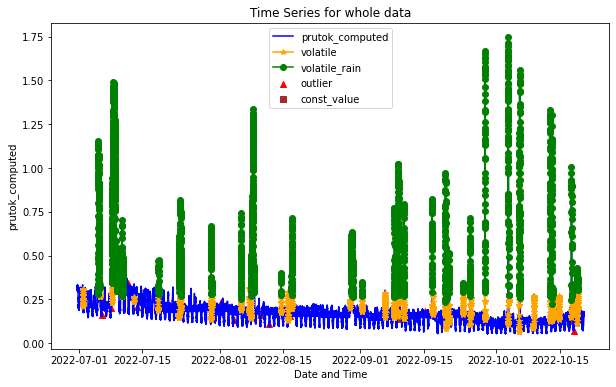

MP2


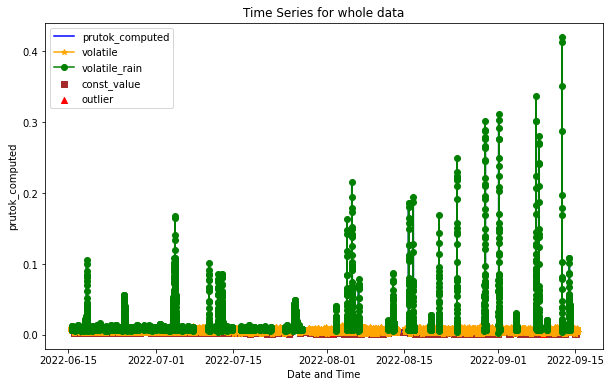

MP3


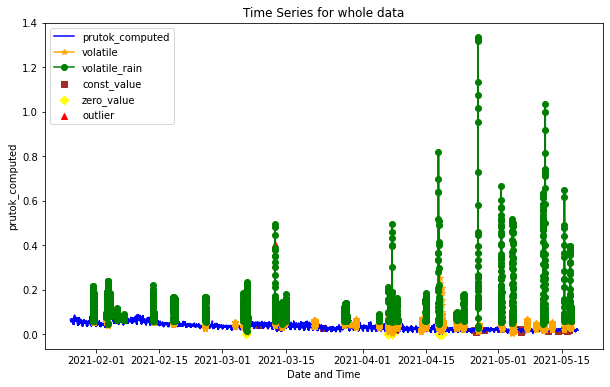

MP4


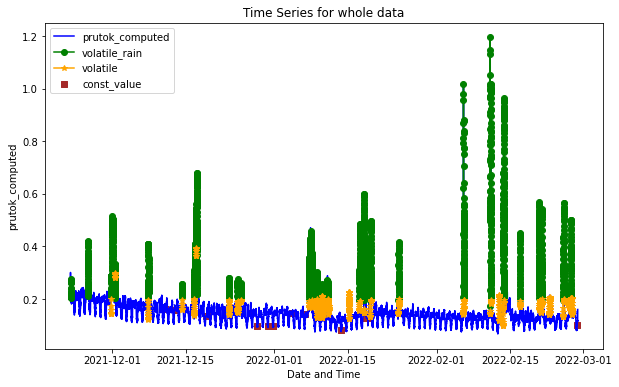

MP5


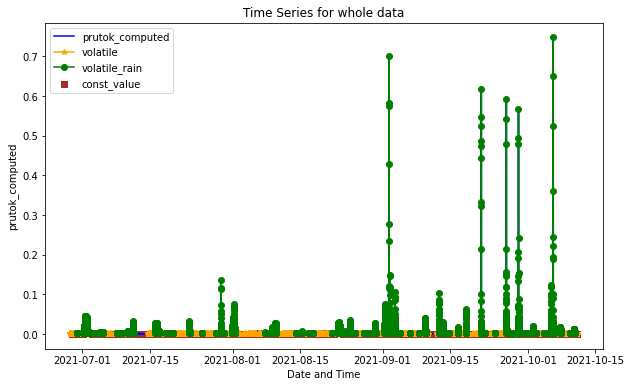

MP6


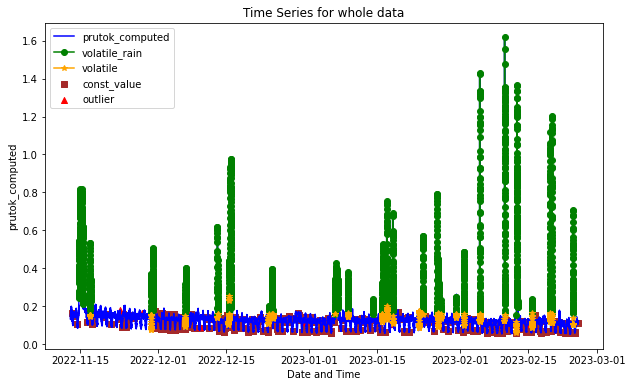

MP7


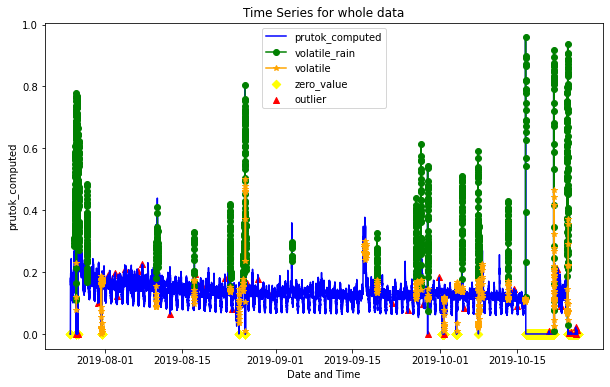

first


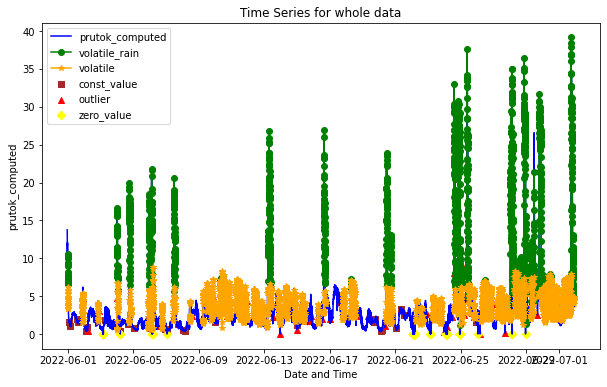

In [27]:
for site in explorer.main_sites:
    print(site)
    explorer.TS_objects[site].plot_categories()

In [69]:
ts_data2 = explorer.TS_objects["MP2"]
subset_ = ts_data2.data["date"].dt.date == pd.to_datetime("2022-08-01").date()
subset3 = ts_data2.data[subset_].index

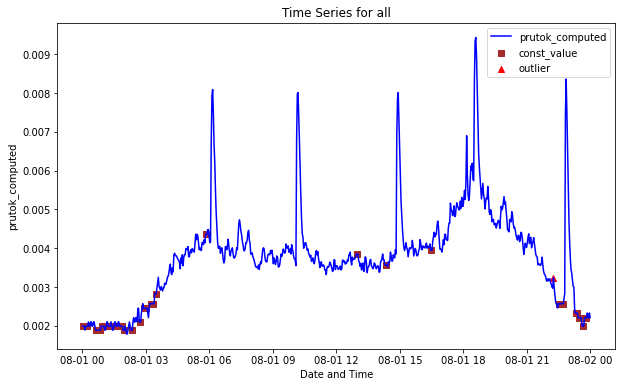

In [70]:
plot_categories(ts_data2.data.loc[subset3], "prutok_computed", "all")

In [ ]:
explorer.TS_objects["MP2"].plot_categories(period = "daily")